In [4]:
import sys
sys.path.insert(0, "/home/gstupp/projects/metaproteomics")

In [5]:
import os
import requests
import pandas as pd
from tqdm import tqdm
from collections import defaultdict, Counter
from glob import glob
import numpy as np
from itertools import chain
import matplotlib
matplotlib.rcParams.update({'font.size': 22})

In [10]:
from metaproteomics.file_processing.blazmass_tools import dta_select_parser, build_pep_quant_dict
from metaproteomics.goatools import obo_parser
goa = obo_parser.GODag()

load obo file /home/gstupp/projects/metaproteomics/metaproteomics/goatools/go-basic.obo
48437 nodes imported


In [7]:
files = glob("data/*/*/*.txt")

In [8]:
files

['data/PA/Triflic/PA triflic 4.txt',
 'data/PA/Triflic/PA triflic 3.txt',
 'data/PA/Triflic/PA triflic 5.txt',
 'data/PA/Sonic/PA sonic 1.txt',
 'data/PA/Sonic/PA sonic 3.txt',
 'data/PA/Sonic/PA sonic 4.txt',
 'data/Jurkat/Triflic/Jurkat triflic 1.txt',
 'data/Jurkat/Triflic/Jurkat triflic test.txt',
 'data/Jurkat/Triflic/Jurkat triflic 2.txt',
 'data/Jurkat/Sonic/Jurkat sonic 7.txt',
 'data/Jurkat/Sonic/Jurkat sonic 1.txt',
 'data/Jurkat/Sonic/Jurkat sonic 8.txt',
 'data/BS/Triflic/BS triflic 3.txt',
 'data/BS/Triflic/BS triflic 1.txt',
 'data/BS/Triflic/BS triflic 2.txt',
 'data/BS/Sonic/BS sonic 3.txt',
 'data/BS/Sonic/BS sonic 4.txt',
 'data/BS/Sonic/BS sonic 2.txt']

In [9]:
df = pd.read_csv("annotations.mapped.gaf", sep="\t", comment="!", header=None)
df = df.rename(columns={1:"id", 4:"go_id", 8:'aspect'})
df = df.query("aspect == 'C'")
df = df.query("go_id != 'GO:0005575'")  # remove 'cellular component'
df.head(2)

,0,id,2,3,go_id,5,6,7,aspect,9,10,11,12,13,14,15,16
2,UniProtKB,A0A024R161,DNAJC25-GNG10,NaN,GO:0043234,GO_REF:0000002,IEA,InterPro:IPR001770|InterPro:IPR015898,C,Guanine nucleotide-binding protein subunit gamma,A0A024R161_HUMAN|hCG_1994888,protein,taxon:9606,20170603,InterPro,NaN,NaN
3,UniProtKB,A0A024R161,DNAJC25-GNG10,NaN,GO:0005622,GO_REF:0000002,IEA,InterPro:IPR001770|InterPro:IPR015898,C,Guanine nucleotide-binding protein subunit gamma,A0A024R161_HUMAN|hCG_1994888,protein,taxon:9606,20170603,InterPro,NaN,NaN


In [10]:
go_annot = df.groupby("id").agg({'go_id': lambda x: set(x)}).to_dict()['go_id']
go_annot['A0A024R161']

{'GO:0005622', 'GO:0005886', 'GO:0043234'}

In [174]:
print(', '.join({goa[x].name: x for x in set(df[df['aspect'] == 'C']['go_id'])}))

extracellular region, intracellular, nuclear chromosome, ribosome, cell, nuclear envelope, microtubule organizing center, cilium, nucleus, nucleolus, chromosome, endosome, proteinaceous extracellular matrix, peroxisome, organelle, cytoplasm, protein complex, endoplasmic reticulum, cytoskeleton, thylakoid, extracellular space, mitochondrion, cytosol, Golgi apparatus, cytoplasmic vesicle, cytoplasmic chromosome, lysosome, nucleoplasm, vacuole, cell wall, external encapsulating structure, plasma membrane, lipid particle


In [45]:
def get_proteins(loci):
    loci = [x for x in loci['loci'] if "|" in x['description']]
    for locus in loci:
        locus['uniprot'] = locus['description'].split("|")[1]
    return loci
locus = next(dta_select_parser(files[9], return_reverse=False))
get_proteins(locus)

[{'Descriptive Name': 'Tubulin alpha-1A chain (Fragment) OS=Homo sapiens GN=TUBA1A PE=4 SV=1 ',
  'EMPAI': 5.4268775,
  'Length': 26,
  'Locus': 0,
  'MolWt': 2704,
  'NSAF': 0.0028739145,
  'Sequence Count': 4,
  'Sequence Coverage': 0.8079999999999999,
  'Spectrum Count': 11,
  'Validation Status': 'U',
  'description': 'tr|F8VXZ7|F8VXZ7_HUMAN',
  'pI': 4.9,
  'reverse': False,
  'uniprot': 'F8VXZ7'}]

In [47]:
def get_go_count(file):
    """
    If a locus has multiple proteins, the go annotations for each protein are used and the spectral count assigned
    is divided by the number of proteins in the locus.
    If a protein has multiple go terms, the spectral count for that protein is divided by the number of GO terms
    """
    descr = dict()
    d = defaultdict(int)
    for locus in dta_select_parser(file, return_reverse=False):
        proteins = get_proteins(locus)
        for p in proteins:
            this_go = go_annot.get(p['uniprot'], [])
            descr[p['uniprot']] = {'go': ";".join(this_go), 'q': locus['quantification'], 
                          'go_name': ";".join([goa[x].name for x in this_go]), 
                          'name': p['Descriptive Name']}
            for go in this_go:
                d[go]+=(locus['quantification']/len(proteins))/len(this_go)
    d = dict(d)
    return d, descr

d,p = get_go_count(files[0])
d

{'GO:0005576': 237.83333333333331,
 'GO:0005615': 97.0,
 'GO:0005618': 32.33333333333333,
 'GO:0005622': 1586.6666666666667,
 'GO:0005623': 1392.9666666666667,
 'GO:0005634': 3.3333333333333335,
 'GO:0005694': 37.166666666666664,
 'GO:0005730': 11.5,
 'GO:0005737': 5420.133333333335,
 'GO:0005739': 269.3333333333333,
 'GO:0005777': 3.0,
 'GO:0005829': 1915.1333333333334,
 'GO:0005840': 640.6666666666667,
 'GO:0005886': 1640.1333333333334,
 'GO:0030312': 751.0,
 'GO:0043226': 92.66666666666666,
 'GO:0043234': 1215.1333333333337}

In [48]:
def get_membrane_count(d):
    # cell wall, plasma membrane
    membrane = {'GO:0005618', 'GO:0005886'}
    membrane_count = sum(count for go,count in d.items() if go in membrane)
    not_membrane_count = sum(count for go,count in d.items() if go not in membrane)
    return membrane_count, not_membrane_count

In [168]:
counts = dict()
all_counts = dict()
for file in tqdm(files):
    d,p = get_go_count(file)
    all_counts[file] = {goa[k].name:v for k,v in d.items()}
    membrane_count, not_membrane_count = get_membrane_count(d)
    counts[file] = (membrane_count, not_membrane_count, np.log(not_membrane_count/membrane_count))
    pd.DataFrame(p).T.to_csv(file + "_go_counts.csv")

100%|██████████| 18/18 [00:03<00:00,  5.28it/s]


In [169]:
df_out = pd.DataFrame({'files': list(counts.keys()),
 'membrane': [x[0] for x in counts.values()],
 'non-membrane': [x[1] for x in counts.values()],
 'ratio': [x[2] for x in counts.values()],
 'method': ["sonic" if "sonic" in file else "tri" for file in counts],
 'cell': [file.split("/")[1] for file in counts]})
df_out = df_out.sort_values(["cell", "method"])
df_out

,cell,files,membrane,method,non-membrane,ratio
2,BS,data/BS/Sonic/BS sonic 4.txt,1262.133333,sonic,14513.866667,2.442301
7,BS,data/BS/Sonic/BS sonic 2.txt,1474.416667,sonic,15578.583333,2.357635
17,BS,data/BS/Sonic/BS sonic 3.txt,1222.316667,sonic,13971.683333,2.436285
0,BS,data/BS/Triflic/BS triflic 1.txt,1112.233333,tri,12265.766667,2.400442
5,BS,data/BS/Triflic/BS triflic 2.txt,1733.883333,tri,21035.116667,2.495830
9,BS,data/BS/Triflic/BS triflic 3.txt,2092.116667,tri,24973.883333,2.479654
13,Jurkat,data/Jurkat/Sonic/Jurkat sonic 1.txt,1033.152608,sonic,19283.167630,2.926618
14,Jurkat,data/Jurkat/Sonic/Jurkat sonic 7.txt,1270.553510,sonic,22353.405834,2.867526
16,Jurkat,data/Jurkat/Sonic/Jurkat sonic 8.txt,795.449164,sonic,20567.650292,3.252568
3,Jurkat,data/Jurkat/Triflic/Jurkat triflic test.txt,303.136117,tri,7763.900345,3.243058


In [170]:
df_out.to_csv("df_out.csv")

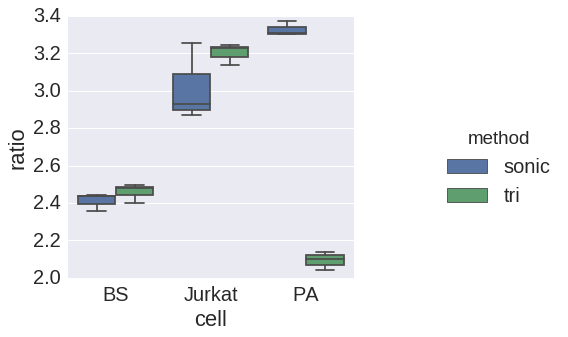

In [171]:
import seaborn as sns
sns.set(font_scale=2)
g = sns.factorplot(x="cell", y="ratio", hue="method", data=df_out, kind="box")
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(10, 6)

In [209]:
all_counts = pd.DataFrame(all_counts)
all_counts.head()

,data/BS/Sonic/BS sonic 2.txt,data/BS/Sonic/BS sonic 3.txt,data/BS/Sonic/BS sonic 4.txt,data/BS/Triflic/BS triflic 1.txt,data/BS/Triflic/BS triflic 2.txt,data/BS/Triflic/BS triflic 3.txt,data/Jurkat/Sonic/Jurkat sonic 1.txt,data/Jurkat/Sonic/Jurkat sonic 7.txt,data/Jurkat/Sonic/Jurkat sonic 8.txt,data/Jurkat/Triflic/Jurkat triflic 1.txt,data/Jurkat/Triflic/Jurkat triflic 2.txt,data/Jurkat/Triflic/Jurkat triflic test.txt,data/PA/Sonic/PA sonic 1.txt,data/PA/Sonic/PA sonic 3.txt,data/PA/Sonic/PA sonic 4.txt,data/PA/Triflic/PA triflic 3.txt,data/PA/Triflic/PA triflic 4.txt,data/PA/Triflic/PA triflic 5.txt
Golgi apparatus,NaN,NaN,NaN,NaN,NaN,NaN,80.439569,71.966568,67.636642,20.472386,22.331316,25.663306,NaN,NaN,NaN,NaN,NaN,NaN
cell,1587.416667,2006.400000,1435.800000,351.400000,500.466667,856.533333,830.339838,1148.537051,743.189309,176.019966,176.958958,317.244220,3414.250000,3211.333333,1417.283333,1248.066667,1392.966667,1111.733333
cell wall,51.250000,38.250000,49.166667,102.000000,110.416667,221.916667,NaN,NaN,NaN,NaN,NaN,NaN,25.166667,31.333333,11.500000,34.000000,32.333333,22.166667
chromosome,11.000000,14.166667,14.000000,21.333333,26.833333,32.500000,638.975840,187.775317,976.876355,124.148775,169.061937,261.142880,43.250000,113.500000,9.750000,11.500000,37.166667,16.666667
cilium,NaN,NaN,NaN,NaN,NaN,NaN,88.161832,111.971212,79.283046,16.281859,18.352710,24.294503,NaN,NaN,NaN,NaN,NaN,NaN


In [210]:
show = ['cell wall'] + list(all_counts.sum(axis=1).sort_values()[-9:].index) + ['other']
all_counts2 = all_counts[all_counts.index.isin(show)].T
other = all_counts[~all_counts.index.isin(show)].sum()
all_counts2['other'] = other

In [211]:
print(show)

['cell wall', 'nucleus', 'extracellular space', 'organelle', 'protein complex', 'plasma membrane', 'cell', 'intracellular', 'cytosol', 'cytoplasm', 'other']


In [212]:
all_counts2.index = all_counts2.index.map(lambda x:x.split("/")[-1].split(".")[0])

In [213]:
all_counts2[show]

,cell wall,nucleus,extracellular space,organelle,protein complex,plasma membrane,cell,intracellular,cytosol,cytoplasm,other
BS sonic 2,51.250000,NaN,NaN,75.750000,777.833333,1423.166667,1587.416667,2139.750000,2046.750000,8331.250000,619.833333
BS sonic 3,38.250000,NaN,NaN,58.500000,670.233333,1184.066667,2006.400000,1819.750000,1742.150000,7107.400000,567.250000
BS sonic 4,49.166667,NaN,NaN,63.583333,714.966667,1212.966667,1435.800000,1897.916667,1676.800000,8183.383333,541.416667
BS triflic 1,102.000000,NaN,NaN,66.500000,366.900000,1010.233333,351.400000,2248.666667,1334.733333,7101.233333,796.333333
BS triflic 2,110.416667,NaN,NaN,82.166667,653.633333,1623.466667,500.466667,4041.083333,1956.550000,12918.300000,882.916667
BS triflic 3,221.916667,1.000000,NaN,123.750000,783.533333,1870.200000,856.533333,4805.416667,2673.533333,14159.700000,1570.416667
Jurkat sonic 1,NaN,2278.250253,2172.257954,2193.969547,1036.113975,1033.152608,830.339838,671.267106,1599.683125,2220.310294,6280.975537
Jurkat sonic 7,NaN,2012.668065,3383.844602,3402.669139,1041.758812,1270.553510,1148.537051,748.960267,1680.236219,3043.350632,5891.381046
Jurkat sonic 8,NaN,2477.212213,2596.867904,2637.001660,970.290394,795.449164,743.189309,647.669473,1438.976452,2224.720620,6831.722268
Jurkat triflic 1,NaN,564.390919,474.883818,499.101938,249.038302,181.450836,176.019966,150.665104,382.252868,591.011250,1486.287275


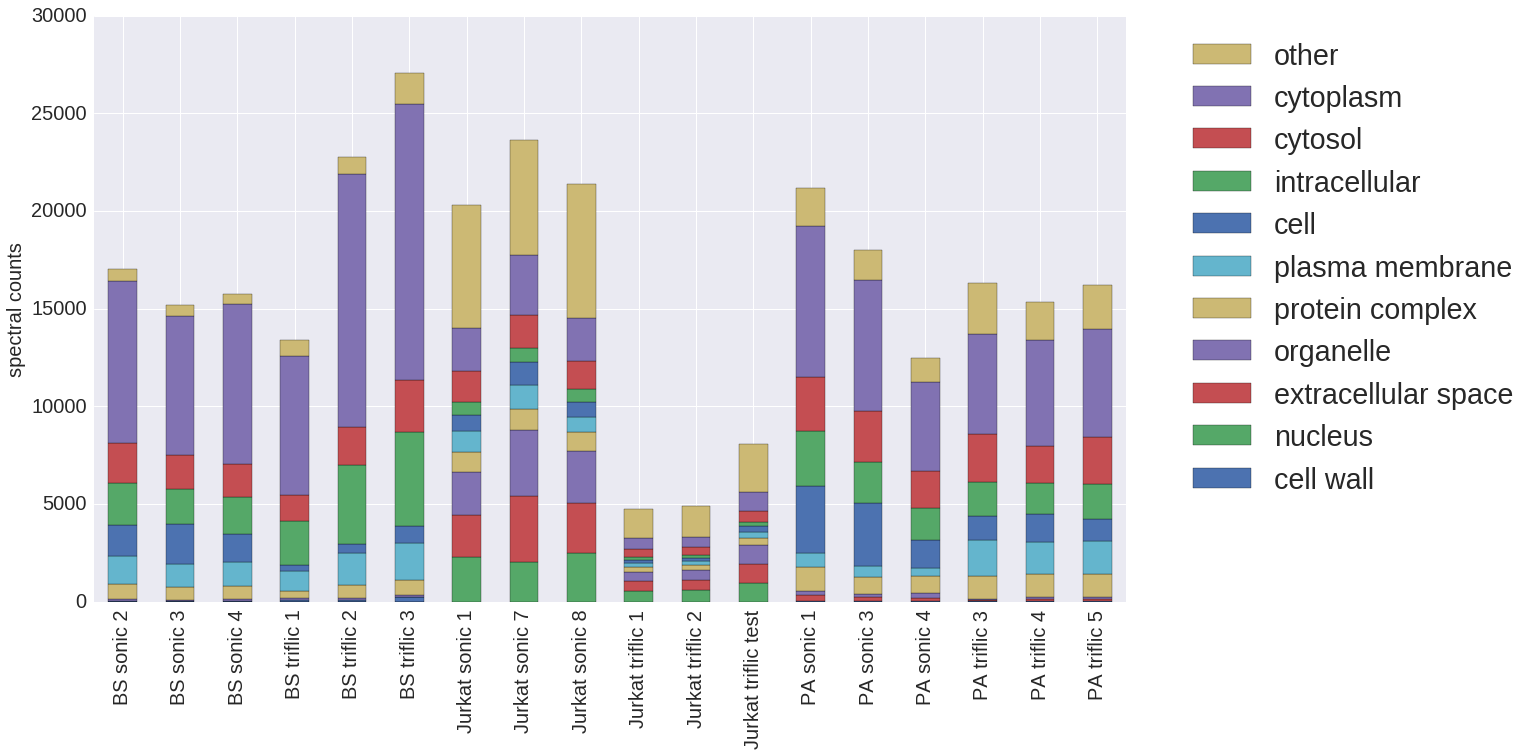

In [214]:
ax = all_counts2[show].plot.bar(stacked=True, legend=False)
ax.set_ylabel("spectral counts")
patches, labels = ax.get_legend_handles_labels()
ax.legend(patches[::-1], labels[::-1], bbox_to_anchor=(1.4, 1), fontsize='large')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)

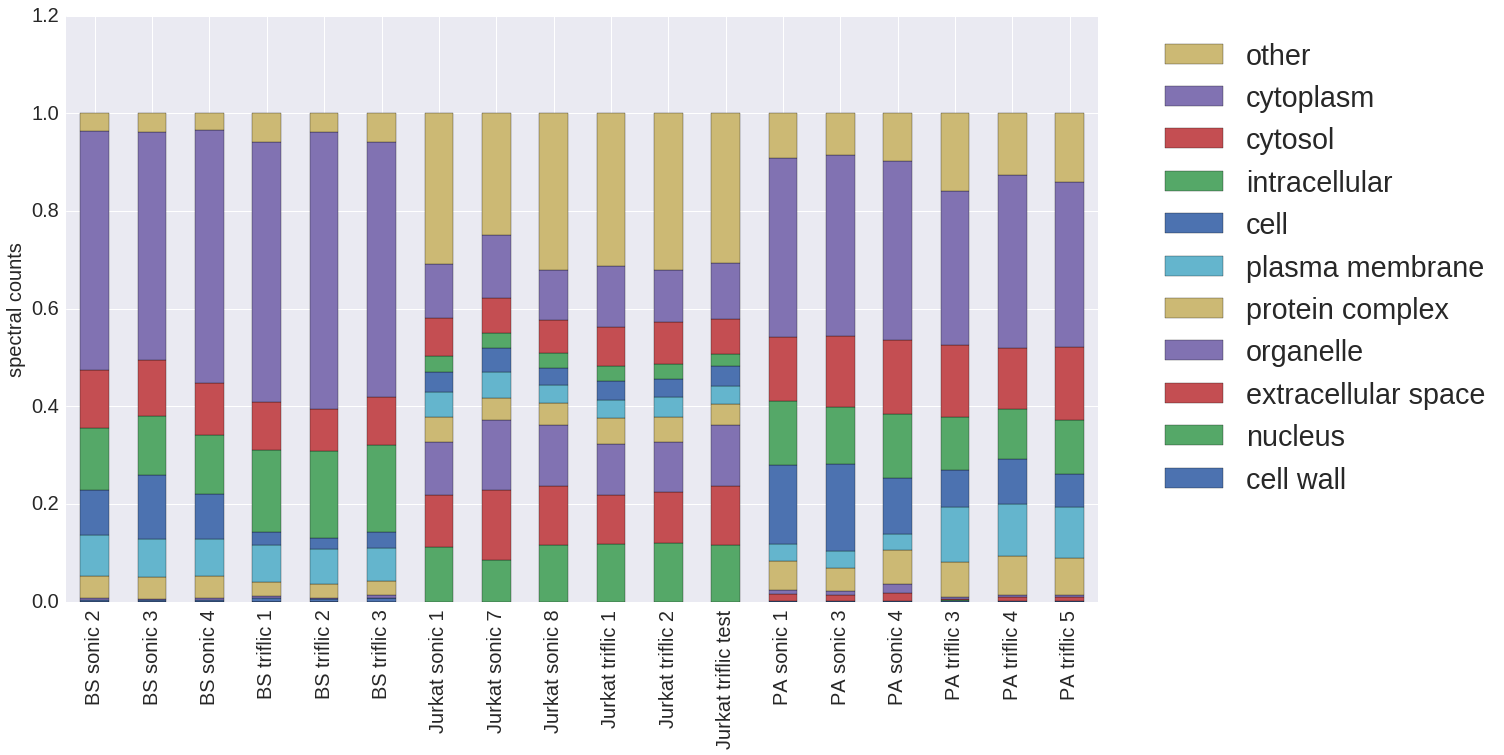

In [215]:
ax = all_counts2.div(all_counts2.sum(1), axis=0)[show].plot.bar(stacked=True, legend=False)
ax.set_ylabel("spectral counts")
patches, labels = ax.get_legend_handles_labels()
ax.legend(patches[::-1], labels[::-1], bbox_to_anchor=(1.4, 1), fontsize='large')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)

In [229]:
df = all_counts2.T
gs = ["BS sonic", "BS triflic", "Jurkat sonic", "Jurkat triflic", "PA sonic", "PA triflic"]
for g in gs:
    df[g] = df[df.columns[df.columns.str.contains(g)]].sum(1)
df = df[gs]
df3 = df.T

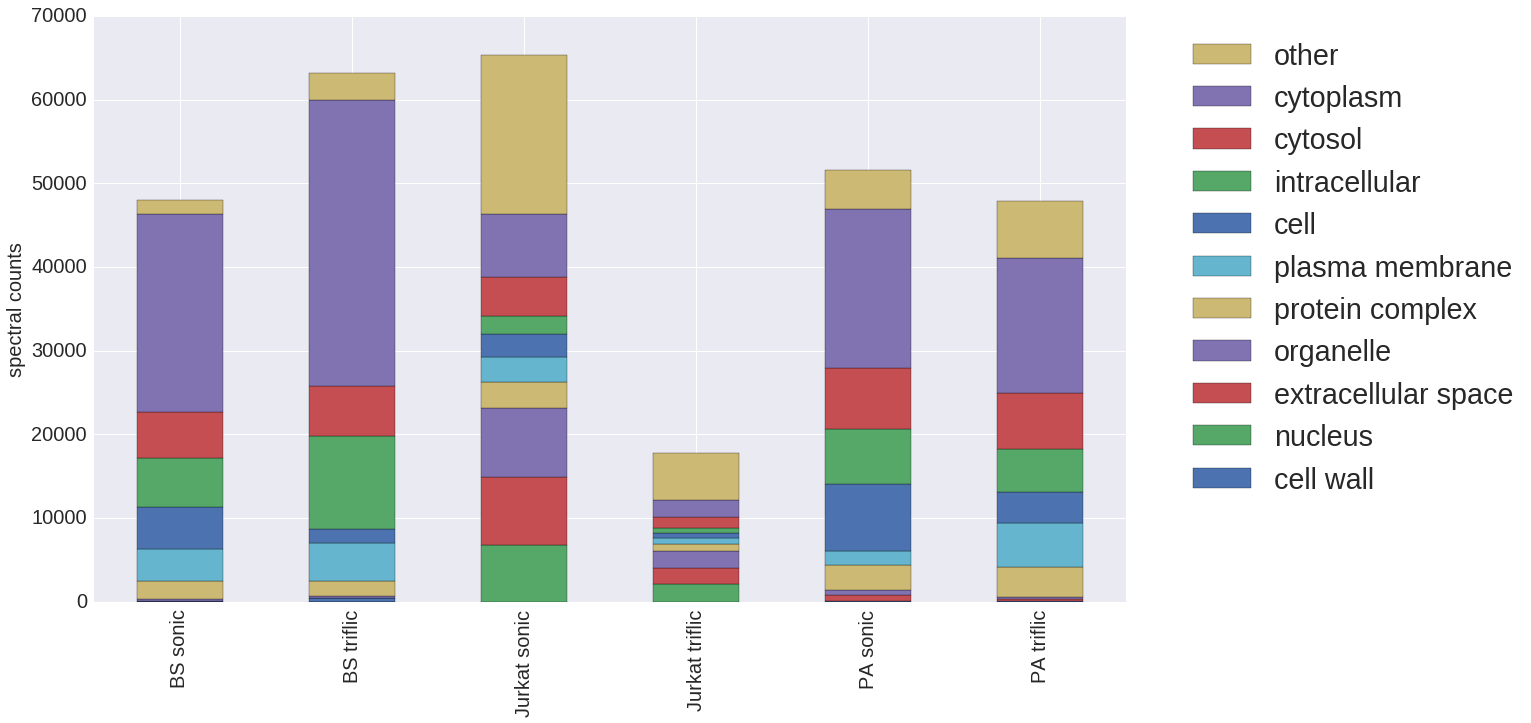

In [230]:
ax = df3[show].plot.bar(stacked=True, legend=False)
ax.set_ylabel("spectral counts")
patches, labels = ax.get_legend_handles_labels()
ax.legend(patches[::-1], labels[::-1], bbox_to_anchor=(1.4, 1), fontsize='large')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)

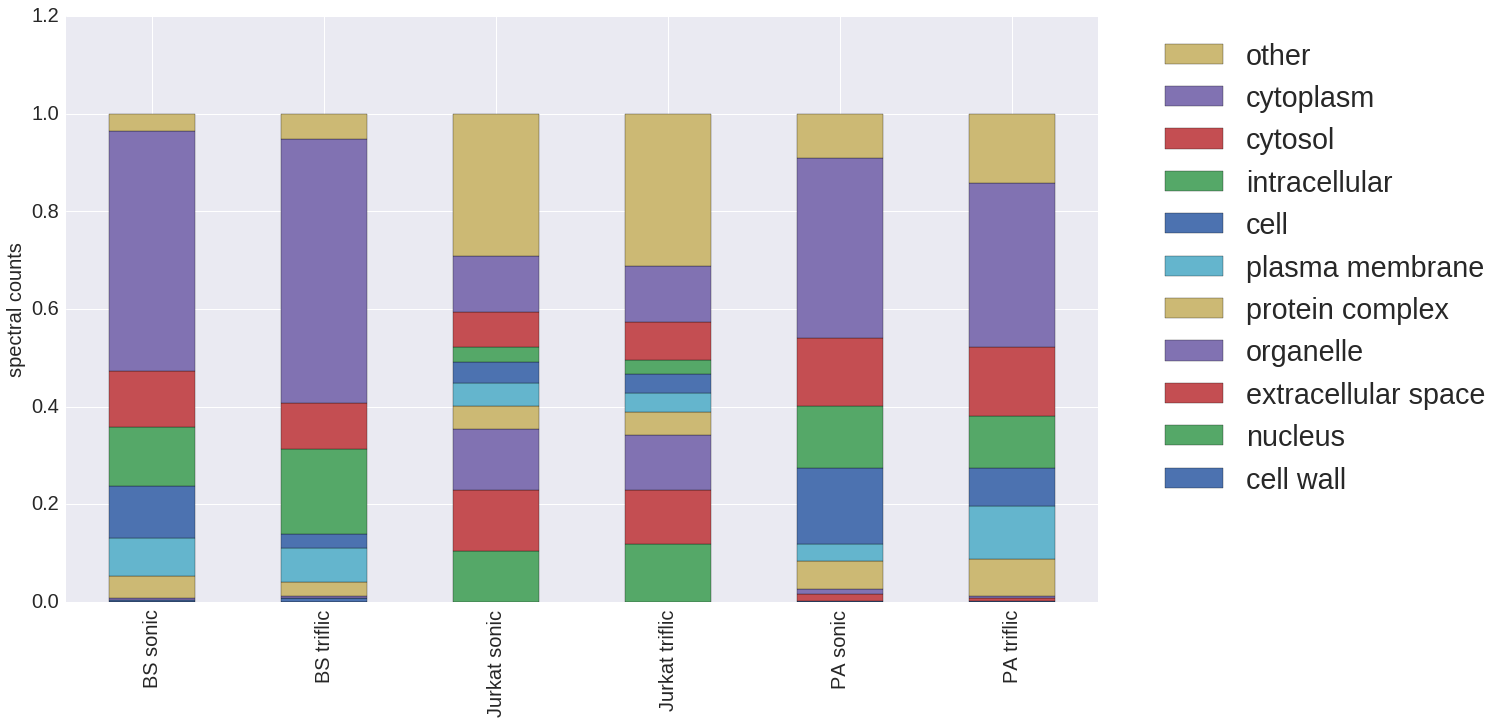

In [231]:
ax = df3.div(df3.sum(1), axis=0)[show].plot.bar(stacked=True, legend=False)
ax.set_ylabel("spectral counts")
patches, labels = ax.get_legend_handles_labels()
ax.legend(patches[::-1], labels[::-1], bbox_to_anchor=(1.4, 1), fontsize='large')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)